# Analysing Hawaiian dictionary definitions

Here I'll be running through the hawaiian dictionary entries to try and find a simple way of extracting the definitions we need for the object recognition app. 

In [1]:
import re
import json
import numpy as np
import pandas as pd

from functools import reduce
from collections import Counter
from nltk.tokenize import word_tokenize, sent_tokenize
%matplotlib inline

In [2]:
def get_terms(filepath):
    '''
    Returns a list of terms from the filepath given
    '''
    with open(filepath, "r") as f:
        return [term for term in f.read().strip().split("\n") if not term == "???"]
    
term_list = get_terms("../../Example_Models/coco_ssd_mobilenet_v1_1.0_quant_2018_06_29/labelmap.txt")
dictionary_data = pd.DataFrame(
    json.load(
        open("../olelo_hawaii/olelo_hawaii.json", "r", encoding = 'utf-8')
    )
)

In [3]:
dictionary_data.head(10)

,definition,dictionary,source_lang,target_lang,term
0,"Kanaka, mea, kama. Also: maka, kino; kaʻaka (s...",Pukui-Elbert,English,Hawaiian,person
1,"ke kino o ke kanaka, wahine, keiki paha.",Andrews,English,Hawaiian,person
2,"Kalaka, kaʻa kalaka, kaʻa ukana.",Pukui-Elbert,English,Hawaiian,truck
3,"Kaʻa. To ride in a car, kau kaʻa, holo kaʻa. P...",Pukui-Elbert,English,Hawaiian,car
4,"Moku, poki. Rowboat, waʻapā. Steamboat, mokuahi.",Pukui-Elbert,English,Hawaiian,boat
5,he waapa.,Andrews,English,Hawaiian,boat
6,Kaʻa ʻōhua; kaʻa uila (electric).,Pukui-Elbert,English,Hawaiian,bus
7,"Paikikala, kaʻa paikikala, kaʻa hehi wāwae.",Pukui-Elbert,English,Hawaiian,bicycle
8,"Paikikala. See basket, bike. ~ chain. Kaula...",Māmaka Kaiao,English,Hawaiian,bicycle
9,"Mokulele, mokuea.",Pukui-Elbert,English,Hawaiian,airplane


## Handling missing terms

Not all of the terms showed up in the online dictionary search. A few of them had to be identified and coded by hand, which we show below:

In [4]:
print("{} terms matched".format(len(dictionary_data.term.unique())))

66 terms matched


In [5]:
unmatched_terms = [term.strip() for term in term_list if not term in dictionary_data.term.values]
print("The following terms had no dictionary match:\n", "\n ".join(unmatched_terms))

The following terms had no dictionary match:
 traffic light
 frisbee
 skis
 snowboard
 sports ball
 baseball bat
 baseball glove
 wine glass
 donut
 potted plant
 laptop
 cell phone
 microwave
 hair drier


In [6]:
# Translated missing terms - Note that ski has no translation in Mo'olelo hawai'i
missing_terms = {
 "traffic light": "kukui alanui",
 "frisbee": "pālele",
 # "skis": null,
 "snowboard": "papa he'e hau",
 "sports ball": "kinipōpō ha'uki",
 "baseball bat": "lā'au kinipōpō",
 "baseball glove": "mikilima pōhili",
 "wine glass": "kī'aha waina",
 "donut": "koneko",
 "potted plant": "mea kanu poho",
 "laptop": "loluila",
 "cell phone": "kelepona",
 "microwave": "'omawawe",
 "hair drier": "mīkini ho'omalo'o oho",
}

missing_terms = pd.DataFrame(missing_terms, index = [1]).transpose().reset_index()
missing_terms.columns = ['term', 'translation']
missing_terms.to_csv('../data/review/missing_terms.csv', index = None)
missing_terms

,term,translation
0,traffic light,kukui alanui
1,frisbee,pālele
2,snowboard,papa he'e hau
3,sports ball,kinipōpō ha'uki
4,baseball bat,lā'au kinipōpō
5,baseball glove,mikilima pōhili
6,wine glass,kī'aha waina
7,donut,koneko
8,potted plant,mea kanu poho
9,laptop,loluila


We want a utility function to match words using Hawaiian orthography, that way we can conveniently filter out English words.

In [7]:
vowels = list('aeiouāēīōū')
consonants = list("hklmnpw'")

In [8]:
def pairwise(iterable):
    it = iter(iterable)
    a = next(it, None)

    for b in it:
        yield (a, b)
        a = b

def is_hawaiian(text, verbose = False):
    '''
    Returns True is the text provided matches Hawaiian orthography
    '''
    # Lowercase text
    text = text.lower()
    # Remove non alphabet characters
    text = re.sub("[^a-zāēīōū\s]", "", text)
    if len(text) == 0:
        # String is empty
        if verbose: print("String is empty after cleaning")
        return False
    if len(text) == 1:
        if text in vowels:
            return True
        else:
            if verbose: print("Single character word {} is not a vowel".format(text))
            return False
    for current_ch, next_ch in pairwise(text):
        if current_ch not in consonants + vowels + [" "]:
            # Character not in hawaiian character set
            if verbose: print("Character '{}' not in hawaiian character set".format(current_ch))
            return False
        if current_ch in consonants:
            # The current character is a consonant, so the next must be a vowel
            if next_ch in vowels:
                # The next character is a vowel, so this is ok
                continue
            else:
                # The next character is not a vowel, this is not ok
                if verbose: print("The consonant '{}' is followed by '{}' instead of a vowel".format(current_ch, next_ch))
                return False
    if not next_ch in vowels:
        # Last character in word is a consonant
        if verbose: print("The last character '{}' is a consonant".format(next_ch))
        return False
    return True

In [9]:
dictionary_data.dictionary.unique()

array(['Pukui-Elbert', 'Andrews', 'Māmaka Kaiao'], dtype=object)

In [10]:
# Rate Māmaka Kaiao first, since it contains modern words
# For culturally accurate definitions, the other dictionaries are more authoritative
dictionary_priority = {
    'Māmaka Kaiao': 1,
    'Pukui-Elbert': 2,
    'Andrews': 3,
}

In [11]:
# Drop Andrews dictionary
dictionary_data = dictionary_data[dictionary_data.dictionary.apply(lambda x: dictionary_priority[x] > 1)]

In [12]:
term = dictionary_data.term.sample().values[0]
print("Term:", term)

dictionaries = dictionary_data.loc[dictionary_data.term == term, 'dictionary']
definitions = dictionary_data.loc[dictionary_data.term == term, 'definition']

for dictionary, definition in zip(dictionaries, definitions):
    print("Dict:", dictionary)
    print("Def:", definition + "\n")

dictionary_data[dictionary_data.term == term]

Term: dining table
Dict: Pukui-Elbert
Def: Papa ʻaina.



,definition,dictionary,source_lang,target_lang,term
90,Papa ʻaina.,Pukui-Elbert,English,Hawaiian,dining table


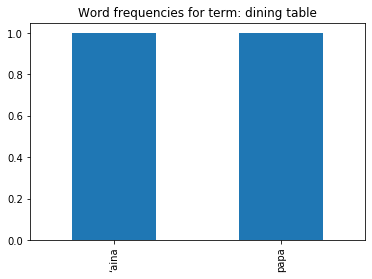

In [13]:
word_counts = Counter()
for defn in definitions:
    for word in word_tokenize(defn):
        word = word.lower()
        if is_hawaiian(word):
            try:
                word_counts[word] += 1
            except KeyError:
                word_counts[word] = 1

pd.Series(word_counts).sort_values(ascending = False).plot(kind = 'bar', title = "Word frequencies for term: {}".format(term))

We want to write a function that can give a best guess translation for a given english term, based on the dictionary results.

We don't expect that it will be 100% correct (or even 60% correct necessarily), but the goal will be to provide suggestions that might make the translation process easier.

In [14]:
term = dictionary_data.sample()['term'].values[0]
print(term)
term_data = dictionary_data[dictionary_data.term == term]
term_data

horse


,definition,dictionary,source_lang,target_lang,term
43,Lio; puaʻa nui huelo huluhulu (old Lā-naʻi nam...,Pukui-Elbert,English,Hawaiian,horse
45,he lio.,Andrews,English,Hawaiian,horse


In [15]:
def get_hawaiian_terms(text):
    '''
    Extracts the hawaiian terms from a given text as a list.
    English words which fit Olelo Hawai'i have not been handled separately
    '''
    word_counts = Counter()
    for word in word_tokenize(text):
        word = word.lower()
        if is_hawaiian(word):
            try:
                word_counts[word] += 1
            except KeyError:
                word_counts[word] = 1
    return word_counts

dictionary_data = dictionary_data.loc[dictionary_data.dictionary != 'Andrews',:]
dictionary_data['hawaiian_words'] = dictionary_data.definition.apply(get_hawaiian_terms)

In [16]:
word_counts = get_hawaiian_terms(" ".join(dictionary_data.definition))
dictionary_data['tfidf'] = dictionary_data.hawaiian_words.apply(lambda x: {k: v / np.log2(word_counts[k]) for k, v in x.items()})
dictionary_data['most_common_word'] = dictionary_data.hawaiian_words.apply(lambda x: max(x.items(), key=lambda v: v[1])[0])
dictionary_data['max_tfidf'] = dictionary_data.tfidf.apply(lambda x: max(x.items(), key=lambda v: v[1])[0])

In [17]:
dictionary_data.sample(10)

,definition,dictionary,source_lang,target_lang,term,hawaiian_words,tfidf,most_common_word,max_tfidf
67,"Puna. Coconut-shell spoon, kīʻoʻe. Spoon for p...",Pukui-Elbert,English,Hawaiian,spoon,"{'puna': 2, 'kīʻoʻe': 2, 'pālau': 2, 'nui': 1}","{'puna': 2.0, 'kīʻoʻe': 1.261859507142915, 'pā...",puna,puna
10,"1. Teach. Aʻo, hoʻomaʻamaʻa.\n2. See railroad....",Pukui-Elbert,English,Hawaiian,train,"{'aʻo': 1, 'hoʻomaʻamaʻa': 1, 'a': 1, 'huʻa': ...","{'aʻo': 0.6309297535714575, 'hoʻomaʻamaʻa': in...",aʻo,hoʻomaʻamaʻa
54,Lāʻau paʻi kinipōpō.,Pukui-Elbert,English,Hawaiian,tennis racket,"{'lāʻau': 1, 'paʻi': 1, 'kinipōpō': 1}","{'lāʻau': 1.0, 'paʻi': 0.3333333333333333, 'ki...",lāʻau,kinipōpō
27,"ʻĪlio (for various kinds, see Haw-Eng. entry a...",Pukui-Elbert,English,Hawaiian,dog,"{'ʻīlio': 6, 'ʻapowai': 1, 'poki': 1, 'welu': ...","{'ʻīlio': 2.3211168434072498, 'ʻapowai': inf, ...",ʻīlio,ʻapowai
43,Lio; puaʻa nui huelo huluhulu (old Lā-naʻi nam...,Pukui-Elbert,English,Hawaiian,horse,"{'lio': 10, 'puaʻa': 1, 'nui': 1, 'huelo': 1, ...","{'lio': 3.010299956639812, 'puaʻa': inf, 'nui'...",lio,puaʻa
32,"ʻAwe, ʻaweʻawe.",Pukui-Elbert,English,Hawaiian,backpack,"{'ʻawe': 1, 'ʻaweʻawe': 1}","{'ʻawe': inf, 'ʻaweʻawe': inf}",ʻawe,ʻawe
53,"Papa heʻe nalu. Of special kinds, the most com...",Pukui-Elbert,English,Hawaiian,surfboard,"{'papa': 1, 'heʻe': 2, 'nalu': 2, 'olo': 1, 'w...","{'papa': 0.5, 'heʻe': 2.0, 'nalu': 2.0, 'olo':...",heʻe,olo
90,Papa ʻaina.,Pukui-Elbert,English,Hawaiian,dining table,"{'papa': 1, 'ʻaina': 1}","{'papa': 0.5, 'ʻaina': 1.0}",papa,ʻaina
68,"1. Vessel. ʻUmeke (for various types, see Haw....",Pukui-Elbert,English,Hawaiian,bowl,"{'ʻumeke': 3, 'ipu': 2, 'pola': 1, 'kānoa': 1,...","{'ʻumeke': 1.8927892607143724, 'ipu': 1.261859...",ʻumeke,kānoa
29,"Kilape, kamelopaki, kamelopadi.",Pukui-Elbert,English,Hawaiian,giraffe,"{'kilape': 1, 'kamelopaki': 1}","{'kilape': inf, 'kamelopaki': inf}",kilape,kilape


In [18]:
term_data = (dictionary_data.groupby(['term']).agg(
    {"hawaiian_words": lambda z: reduce(lambda x, y: x + y, z),
     "definition": lambda x: "\n".join(x)})
    .reset_index())
term_data['tfidf'] = term_data.hawaiian_words.apply(lambda x: {k: v / np.log2(word_counts[k]) for k, v in x.items()})
term_data['most_common_word'] = term_data.hawaiian_words.apply(lambda x: max(x.items(), key=lambda v: v[1])[0])
term_data['max_tfidf'] = term_data.tfidf.apply(lambda x: max(x.items(), key=lambda v: v[1])[0])

In [19]:
# Save the term data to a csv for human review
term_data[['definition', 'term', 'most_common_word', 'max_tfidf']].to_csv("../data/review/olelo-hawaii.csv", index = False)